In [40]:
import pandas as pd
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_squared_error as MSE
from sklearn.multioutput import MultiOutputRegressor
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce

In [41]:
target = 'NEE'

model = ['rcef_RandomForestRegressor', 'rcef_RidgeCV', 'rcef_XGBRegressor', 'xgboost'] 

extracted_features = model[-1]

In [42]:
# loads all data sets into a dict
def load_datasets(dirs: list, load_path: str) -> dict:
    files = ['soil_c','surf_water','flux_soc','soil_water','n_flux','p_flux','temp', 
         'plant_c','plant_n','plant_p','canopcy_c','plant_stress','photosynthesis','plant_growth']
    
    #files.append('soil_temp', 'canopy_temp') missing 
    datasets = {}
    
    for dr in dirs:
        csv_list = []
        path = 'datasets/' + dr + load_path
        for f in files:
            df = pd.read_csv(os.path.join(path,f + '.csv'))
            df.drop(df.columns[0], axis=1)

            csv_list.append(df)


        data_dict = {}
        for i in range (len(csv_list)):
            data_dict[files[i]] = csv_list[i]

        datasets[dr] = data_dict

    return datasets

dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']

datasets = load_datasets(dirs, '/csv_outs/with_plant_soil_details/')

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/warm_temp_maize_soybean_irrigated/csv_outs/with_plant_soil_details/soil_c.csv'

In [4]:
def rename_dupes(suffix: str, df: pd.DataFrame, dupes: list) -> pd.DataFrame:
    for col in df.columns:
        if col in dupes:
            df.rename(columns={col: col + suffix}, inplace=True)
    return df

def average_numbered_columns(df):
    numbered_cols = [col for col in df.columns if '_' in col and col.split('_')[-1].isdigit()]

    col_groups = {}
    for col in numbered_cols:
        prefix = '_'.join(col.split('_')[:-1])
        if prefix not in col_groups:
            col_groups[prefix] = []
        col_groups[prefix].append(col)

    # calculate averages and add new columns
    for prefix, cols in col_groups.items():
        avg_col_name = prefix
        avg_col_values = df[cols].mean(axis=1)
        df[avg_col_name] = avg_col_values

    # drop numbered columns
    df = df.drop(columns=numbered_cols)

    return df

# turn all csv's to one dataframe
def to_pd(df: dict, handle_dupes: bool, flatten_num_cols: bool) -> pd.DataFrame:
    x = pd.DataFrame()
    for file_name in df:
        cur = df[file_name]
            
        x = pd.concat([x, df[file_name]], axis = 1)
        
    cheeky_col = 'unnamed.1'
    cheeky_col2 = 'Unnamed: 0'
    if cheeky_col in x.columns:
        x = x.drop([cheeky_col], axis=1)
    elif cheeky_col2 in x.columns:
         x = x.drop([cheeky_col2], axis=1)
    x = x.drop(['DATE'], axis=1)

    if flatten_num_cols:
        x = average_numbered_columns(x)
        
    x = x.loc[:,~x.columns.duplicated()].copy()
    
    one_hot = pd.get_dummies(x['GROWTH_STG'])
    x= x.drop('GROWTH_STG',axis = 1)
    # Join the encoded df
    x = x.join(one_hot)

    x.columns = x.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
    
    return x

df_dry = to_pd(datasets['warm_temp_maize-soybean_dryland'], True, True)
df_irr = to_pd(datasets['warm_temp_maize_soybean_irrigated'], True, True)
df_cool = to_pd(datasets['cool_temp_maize_soybean'], True, True)

# NEE = GPP - ER:
#GPP = GROSS PRIMARY PRODUCTION (TOTAL C INTAKE) 
#ER = total C uptake =  ECO_RH + ECO_RA =  autotrophic + heterotrophic respiration 
#NPP = GPP + ECO_RA
df_dry['NEE'] = df_dry['ECO_NPP'] - df_dry['ECO_RH']
df_irr['NEE'] = df_irr['ECO_NPP'] - df_irr['ECO_RH']
df_cool['NEE'] = df_cool['ECO_NPP'] - df_cool['ECO_RH']

df= pd.concat([df_dry, df_irr, df_cool])
y = df[target].copy()
#y = df[target].copy()
#df = df.drop(target, axis=1)

In [5]:
df

,DOY,SOIL_CO2_FLUX,ECO_CO2_FLUX,CH4_FLUX,O2_FLUX,CO2_LIT,O2_LIT,H_EVAPN,H_RUNOFF,H_H_SEDIMENT,...,EMERGENCE,END_SEED_FILL,FLORAL_INIT.,JOINTING,NOT_ALIVE,SEED_FILL,SEED_MASS_SET,SEED_NO._SET,NEE,PLANTING
0,0.520833,-0.255585,-0.255585,0.000761,0.276700,370.324575,15.367582,-0.000728,0.0,0.0,...,0,0,0,0,1,0,0,0,0.236561,NaN
1,1.520833,-0.241709,-0.241709,0.000744,-0.168380,370.360742,15.798648,-0.009315,0.0,0.0,...,0,0,0,0,1,0,0,0,0.458370,NaN
2,2.520833,-0.272869,-0.272869,0.000786,-0.006056,370.420192,14.854394,-0.009618,0.0,0.0,...,0,0,0,0,1,0,0,0,0.718199,NaN
3,3.520833,-0.649682,-0.649682,0.000937,0.387433,370.668192,14.012000,-0.004694,0.0,0.0,...,0,0,0,0,1,0,0,0,1.315061,NaN
4,4.520833,-0.315353,-0.315353,0.000760,0.391184,370.359367,15.584626,-0.000703,0.0,0.0,...,0,0,0,0,1,0,0,0,1.592673,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,360.520833,-0.475121,-0.475121,0.000298,0.412722,360.741696,15.299666,0.001420,0.0,0.0,...,0,0,0,0,1,0,0,0,1578.580400,0.0
2918,361.520833,-0.482619,-0.482619,0.000296,0.653159,360.727604,15.049338,-0.000560,0.0,0.0,...,0,0,0,0,1,0,0,0,1579.076800,0.0
2919,362.520833,-0.463160,-0.463160,0.000293,0.377447,360.784450,15.356356,0.008237,0.0,0.0,...,0,0,0,0,1,0,0,0,1579.545200,0.0
2920,363.520833,-0.476328,-0.476328,0.000299,0.924370,360.285500,15.917075,-0.001439,0.0,0.0,...,0,0,0,0,1,0,0,0,1580.008600,0.0


## Using averaged weather variables, along with planting details as features

In [6]:
avg_w_ins = ['DOY', 'RADN', 'TMAX_AIR', 'TMIN_AIR',  'WIND', 'HMIN_AIR', 'HMAX_AIR',
       'D_W_PRECN','TMAX_SOIL', 'TMIN_SOIL']


planting_ins = ['initial planting density (m-2)', 'seeding depth (m)']

# add planting data for each DOY, across all planting years
# our datasets have 6 planting ins 
for i in range(1,7):
    planting_ins.append(planting_ins[0] + str(i))
    planting_ins.append(planting_ins[1] + str(i))
    

soil_prfl_vars = ["initial bulk density (Mg m-3,0=water) ","sand contents (kg Mg-1)","silt contents (kg Mg-1)",
    "rock fraction","ph","SOC (kg Mg-1)" ]

features = avg_w_ins + planting_ins + soil_prfl_vars

df = df[ features ]

In [28]:
xgbFeatImp = pd.read_csv('feature_analysis/xgboost/FeaturesImportance'  + target  + 'weather_soil_data' + '.csv')
feat_cols = []
for i in range(len(xgbFeatImp.values)):
    feat_cols.append(xgbFeatImp.values[i][0])

y = df[target].copy()
x = df[feat_cols]

X_train, X_test, y_train, y_test = train_test_split(
   x, y, test_size=0.33, random_state=41)

In [ ]:
for entr in x.columns:
    x[entr] = preprocessing.normalize([x[entr]])[0]
y = pd.Series(preprocessing.normalize([y])[0], name='NEE')

In [27]:
x

,TMAX_AIR,TMAX_SOIL,TMIN_AIR,D_W_PRECN,WIND,HMAX_AIR,HMIN_AIR,TMIN_SOIL,RADN,initial planting density (m-2)1,DOY
0,0.001619,0.000130,-0.002727,0.000000,0.010828,0.004969,0.005058,0.000082,0.003110,0.009389,0.000026
1,0.001218,0.000130,-0.005492,0.000000,0.008070,0.004965,0.004057,0.000076,0.004791,0.009389,0.000077
2,0.005068,0.000147,-0.006413,0.000000,0.008033,0.006276,0.003766,0.000071,0.005737,0.009389,0.000128
3,0.004846,0.000148,-0.000921,0.001131,0.012282,0.007070,0.005826,0.000081,0.002641,0.009389,0.000178
4,0.002075,0.000117,-0.004319,0.000000,0.012019,0.005533,0.004458,0.000078,0.001591,0.009389,0.000229
...,...,...,...,...,...,...,...,...,...,...,...
2917,0.000501,-0.018635,-0.010797,0.000000,0.013171,0.003866,0.002617,0.018389,0.003501,0.009995,0.018258
2918,0.001836,-0.018635,-0.007539,0.000000,0.014183,0.004451,0.003681,0.018389,0.002512,0.009995,0.018309
2919,0.000389,-0.018636,-0.008098,0.001939,0.012553,0.004991,0.003480,0.018388,0.001462,0.009995,0.018360
2920,-0.004228,-0.018637,-0.022525,0.002586,0.030061,0.002536,0.000647,0.018387,0.004518,0.009995,0.018410


In [31]:
y

0       0.000003
1       0.000006
2       0.000009
3       0.000017
4       0.000020
          ...   
8761    0.019906
8762    0.019912
8763    0.019918
8764    0.019924
8765    0.019929
Name: NEE, Length: 8766, dtype: float64

### AmeriFLUX USNE Dataset irrigated maize-soybean, years 2015- 2021

In [ ]:
observed_df = pd.read_csv('datasets/extractedNEE_CUT_REF_NIGHT.csv')
observed_df['initial planting density (m-2)1'] = 0

x_observed = observed_df[feat_cols]
y_observed = observed_df['NEE']

for entr in x_observed.columns:
    x_observed[entr] = preprocessing.normalize([x_observed[entr]])[0]
y_observed = pd.Series(preprocessing.normalize([y_observed])[0], name='NEE')

X_train, X_test, y_train, y_test = train_test_split(
   x_observed, y_observed, test_size=0.33, random_state=41)

In [35]:
x_observed

,TMAX_AIR,TMAX_SOIL,TMIN_AIR,D_W_PRECN,WIND,HMAX_AIR,HMIN_AIR,TMIN_SOIL,RADN,initial planting density (m-2)1,DOY
0,-0.008448,0.002943,-0.012605,0.000000,0.017072,0.009676,0.009852,0.005291,0.009351,0.0,0.000053
1,-0.007237,0.003120,-0.009287,0.000000,0.010835,0.009669,0.007903,0.004961,0.009390,0.0,0.000154
2,-0.009198,0.002920,-0.011451,0.004675,0.021395,0.012222,0.007335,0.004711,0.009432,0.0,0.000255
3,-0.021263,0.001994,-0.022331,0.003280,0.027115,0.013767,0.011348,0.005252,0.009477,0.0,0.000356
4,-0.014926,0.002278,-0.016221,0.001424,0.020603,0.010775,0.008683,0.005157,0.009527,0.0,0.000458
...,...,...,...,...,...,...,...,...,...,...,...
2187,-0.000863,0.002748,-0.003106,0.002816,0.023302,0.012815,0.009976,0.005336,0.009234,0.0,0.036606
2188,-0.005282,0.002588,-0.006845,0.000003,0.012708,0.012827,0.009566,0.005323,0.009258,0.0,0.036707
2189,-0.005136,0.002437,-0.005813,0.046197,0.020563,0.012035,0.008217,0.005196,0.009285,0.0,0.036808
2190,-0.008375,0.002307,-0.012196,0.000000,0.018173,0.010686,0.006136,0.004789,0.009316,0.0,0.036909


In [59]:
X_train, X_test, y_train, y_test = train_test_split(
   x, y, test_size=0.33, random_state=41)

In [32]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1.0,
                        learning_rate=0.01, max_depth= 12,n_estimators = 5000,
                        reg_alpha= 1e-09,reg_lambda= 57.75731177426089, subsample = 0.7282316492848115,
                        seed = 123)

In [33]:
# Fitting the model
xgb_r.fit(x, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [36]:
# Predict the model
pred = xgb_r.predict(X_test)

RMSE :  0.012674


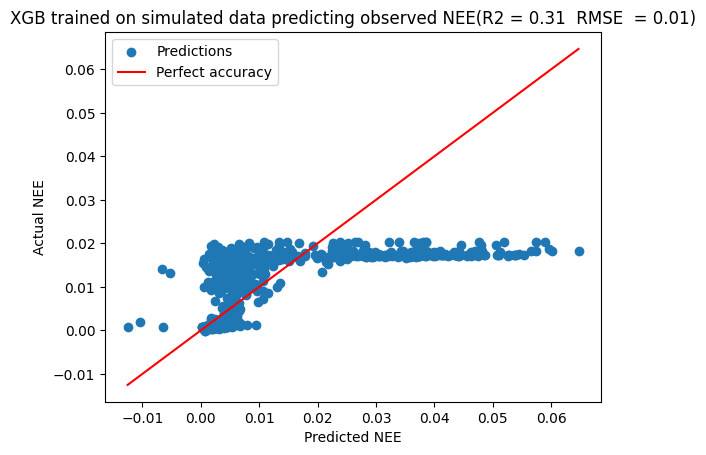

In [38]:
# Calculate R2 score
r2 = R2(y_test, pred)

rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

# Create scatter plot
plt.scatter(y_test, pred)

# Plot a red line for perfect accuracy
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color='r')

# Add title and legend
plt.title("XGB trained on simulated data predicting observed " + target +  "(R2 = %0.2f  RMSE  = %0.2f)" %  (r2, rmse))
plt.legend(['Predictions', 'Perfect accuracy'], loc='upper left')
plt.xlabel("Predicted NEE")
plt.ylabel("Actual NEE")

plt.savefig("results/XGB_sim_data_only_predicting_amerflux" + target + "with_planting_details.png" )
# Show plot
plt.show()

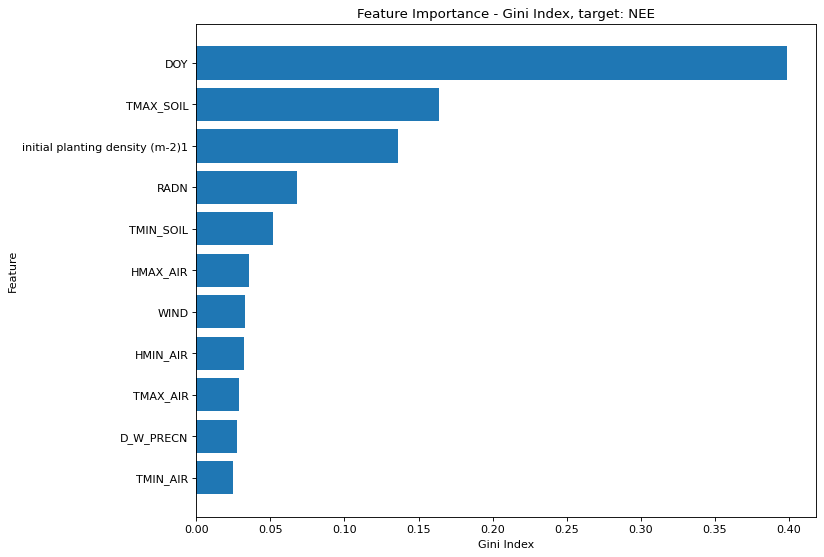

In [39]:
importances = pd.DataFrame({'GINI': xgb_r.feature_importances_}, index=x_observed.columns).sort_values(by='GINI', ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8), dpi=80)
plt.barh(importances.index, importances['GINI'])

# Add title and axis labels
plt.title('Feature Importance - Gini Index, target: NEE')
plt.xlabel('Gini Index')
plt.ylabel('Feature')

plt.savefig('results/FeatureImportanceGB_sim_data_only_predicting_amerflux' + target + "with_planting_details.png")
# Show the plot
plt.show()

In [15]:
g = importances[importances > 0.0001].dropna()

In [17]:
g

,GINI
TMAX_AIR,0.003530
TMAX_SOIL,0.005621
TMIN_AIR,0.005978
D_W_PRECN,0.006330
WIND,0.008331
HMAX_AIR,0.009335
HMIN_AIR,0.010030
TMIN_SOIL,0.014655
RADN,0.080486
initial planting density (m-2)1,0.201666


In [18]:
os.makedirs('feature_analysis/xgboost', exist_ok=True)  
g.to_csv('feature_analysis/xgboost/FeaturesImportance'  + target  + 'weather_soil_data' + '.csv')  